In [ ]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from sklearn.utils import class_weight
from keras.applications.inception_v3 import preprocess_input
from keras.applications import InceptionV3, ResNet50
from keras.models import Sequential, load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend

In [ ]:
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [3]:
#Asign GPU for train
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

In [25]:
train_path = './data/train'
test_path = './data/test'
val_path = './data/val'

In [26]:
# train_datagen = ImageDataGenerator(rescale=1./255.,
#                                   horizontal_flip=True,
#                                   rotation_range=80,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   zoom_range=0.2,
#                                   shear_range=0.2,
#                                   preprocessing_function=preprocess_input
#                                   )


train_datagen = ImageDataGenerator(rescale=1./255.,
                                  horizontal_flip=True,
                                  rotation_range=10,
                                  width_shift_range=.1,
                                  height_shift_range=.1)


validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)


test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)                                               

Found 16448 images belonging to 11 classes.
Found 919 images belonging to 11 classes.
Found 5 images belonging to 11 classes.


In [85]:
x_train,y_train = next(train_generator)

x_test,y_test = next(validation_generator)

In [86]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights = dict(enumerate(class_weights))
class_weights

/home/jfh/miniconda3/envs/project_env/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10], y=[ 0  0  0 ... 10 10 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.9811500835122883,
 1: 0.9275885404917663,
 2: 1.3870804520155169,
 3: 0.9040342970209959,
 4: 0.9487771112136595,
 5: 0.8734069668649108,
 6: 1.1208940984053428,
 7: 0.9811500835122883,
 8: 1.139689578713969,
 9: 1.1792371666188701,
 10: 0.8065117191330784}

In [43]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
#     bn = BatchNormalization()(input_tensor)
    x = base_model(input_tensor)
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
#     x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [93]:
base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=(224,224,3))
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(11, activation='softmax')(class1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 111, 111, 32) 96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_377[0][0]    
_______________________________________________________________________________________

In [89]:
# keras.backend.clear_session()

model = create_model(
    input_shape=(224,224,3), 
    n_out=11)

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
batch_normalization_376 (Bat (None, 224, 224, 3)       12        
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_376 (Conv2D)          (None, 5, 5, 128)         262272    
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [94]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [95]:
model.layers[2].trainable = False
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(lr=.0001),
    metrics=['accuracy'])

In [96]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

file_path="./model/IncV3.h5"

# red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)

# checkpoint = ModelCheckpoint(file_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

# early = EarlyStopping(monitor="accuracy", mode="max", patience=15, verbose=1, restore_best_weights=True)

# mc_top = ModelCheckpoint('./model/InceptionV3.h5', save_best_only=True, monitor='val_accuracy', verbose=1, save_weights_only=False)
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)

callbacks_list = [checkpoint, early, red_lr]



history = model.fit(train_generator, 
                    epochs=100, 
                    shuffle=True, 
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=validation_generator,
                    class_weight=class_weights,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/100
514/514 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.8062
Epoch 00001: val_loss improved from inf to 0.22168, saving model to ./model/IncV3.h5
514/514 [==============================] - 119s 232ms/step - loss: 0.6203 - accuracy: 0.8062 - val_loss: 0.2217 - val_accuracy: 0.9375
Epoch 2/100
514/514 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9482
Epoch 00002: val_loss did not improve from 0.22168
514/514 [==============================] - 108s 211ms/step - loss: 0.1551 - accuracy: 0.9482 - val_loss: 0.2650 - val_accuracy: 0.9286
Epoch 3/100
514/514 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9667
Epoch 00003: val_loss improved from 0.22168 to 0.17613, saving model to ./model/IncV3.h5
514/514 [==============================] - 116s 225ms/step - loss: 0.0991 - accuracy: 0.9667 - val_loss: 0.1761 - val_accuracy: 0.9453
Epoch 4/100
514/514 [==============================] - ETA: 0s - loss: 0.0781 -

In [97]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 45ms/step - loss: 1.7128e-05 - accuracy: 1.0000


In [98]:
val_steps_per_epoch=np.ceil(validation_generator.samples/validation_generator.batch_size)

In [100]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

29/29 [==============================] - 21s 726ms/step - loss: 0.0766 - accuracy: 0.9815
Final loss: 0.08
Final accuracy: 98.15%


In [20]:
model=load_model('./model/IncV3.h5')

In [9]:
network = load_model('./model/InceptionV3.h5')

In [10]:
network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 5, 5, 128)         262272    
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               163891

In [37]:
steps = val_steps_per_epoch

In [51]:
proof = np.array(network.predict(validation_generator,
                                steps = val_steps_per_epoch,
                                verbose=1,
                                workers=10,
                                max_queue_size=64))

29/29 [==============================] - 2s 64ms/step


In [12]:
x_test,y_test = next(validation_generator)

In [15]:
val_steps_per_epoch=np.ceil(validation_generator.samples/validation_generator.batch_size)
final_loss, final_accuracy = network.evaluate(validation_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

29/29 [==============================] - 17s 573ms/step - loss: 0.4684 - accuracy: 0.8585
Final loss: 0.47
Final accuracy: 85.85%


In [13]:
test_loss, test_accuracy =network.evaluate(x_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.4771 - accuracy: 0.9062


In [95]:
predictions = network.predict(x_test)
np.argmax(predictions, axis=-1)

array([5, 7, 5, 7])

In [96]:
class_names[np.argmax(predictions, axis=-1)]

array(['Gibson_Es', 'Gibson_Sg', 'Gibson_Es', 'Gibson_Sg'], dtype='<U19')

In [20]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load('./data/test/gibson_ES/02.jpg')
my_model.predict(image)

array([[3.0572131e-12, 1.3727159e-12, 2.1948869e-12, 2.3803345e-11,
        2.8725107e-09, 1.0000000e+00, 4.0446739e-13, 1.4554336e-10,
        3.5337381e-14, 8.7256999e-12, 2.8399332e-09]], dtype=float32)

In [21]:
predictions = my_model.predict(image)

In [22]:
classes = np.argmax(predictions, axis = 1)

In [23]:
classes

array([5])

In [31]:
list(class_names[np.argmax(predictions, axis=-1)])

['Gibson_Es']

In [73]:
label_names=list(validation_generator.class_indices.keys())

In [74]:
label_names

['fender_jaguar',
 'fender_jazzmaster',
 'fender_mustang',
 'fender_stratocaster',
 'fender_telecaster',
 'gibson_ES',
 'gibson_Flying_V',
 'gibson_SG',
 'gibson_explorer',
 'gibson_firebird',
 'gibson_les_paul']

In [27]:
class_names = sorted(validation_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Fender_Jaguar', 'Fender_Jazzmaster', 'Fender_Mustang',
       'Fender_Stratocaster', 'Fender_Telecaster', 'Gibson_Es',
       'Gibson_Flying_V', 'Gibson_Sg', 'Gibson_Explorer',
       'Gibson_Firebird', 'Gibson_Les_Paul'], dtype='<U19')

In [17]:
from keras_preprocessing.image import ImageDataGenerator
test_path = './data/test'
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)   

Found 5 images belonging to 11 classes.


In [22]:
x_test,y_test = next(test_generator)

In [28]:
predicted = model.predict(x_test)
predicted_id = np.argmax(predicted, axis=-1)
predicted_label = class_names[predicted_id]

label_id = np.argmax(y_test, axis=-1)

In [29]:
predicted_id

array([5, 7, 7, 1, 4])

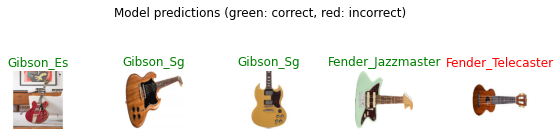

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(5):
    plt.subplot(6,5,n+1)
    plt.imshow(x_test[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [5]:
def plot_training(history, metrics: list = ('loss',), figsize: tuple = (12, 5)):
    """
    plots training selected metrics for every batch
    """
    epochs = range(1, len(history.history[metrics[0]]) + 1)

    fig, ax_arr = plt.subplots(1, len(metrics), figsize=figsize)

    if not isinstance(ax_arr, np.ndarray):
        ax_arr = np.array(ax_arr).reshape(1, )

    for i, metric in enumerate(metrics):
        ax_arr[i].plot(epochs, history.history[metric], color='k', linestyle='solid', label=metric, linewidth=2)
        ax_arr[i].plot(epochs, history.history[f"val_{metric}"], color='r', linestyle='dotted',
                       label=f'validation {metric}')
        ax_arr[i].set_ylabel(metric)
        ax_arr[i].set_xlabel('epochs')
        ax_arr[i].grid()
        ax_arr[i].legend()
    plt.show()

In [127]:
def plot_image_pred(images: np.ndarray,
                    labels: np.ndarray,
                    preds: np.ndarray,
                    indexes: list,
                    class_names: list = None, 
                    figsize: tuple = (8, 4)):
# def plot_image_pred(images, labels, preds, indexes, class_names, figsize: tuple = (8,4)):

        for index in indexes:
        
            predicted_probas = preds[index]
            true_index = labels[index]
            predicted_index = np.argmax(predicted_probas)
            
            if class_names:
                true_class = class_names[true_index]
                predicted_class = class_names[predicted_index]

            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figsize)

            axes[0].imshow(images[index]);
            axes[0].axis('off')
            axes[0].set_title(f"predicted class: {predicted_class if class_names else predicted_index}", 
                              color='blue' if true_index == predicted_index else 'red')

            axes[1].barh(class_names if class_names else [str(i) for i in range(len(predicted_probas))],
                         predicted_probas, 
                         color='black')
            axes[1].get_children()[predicted_index].set_color('red')
            axes[1].get_children()[true_index].set_color('blue')
            axes[1].set_xlim(0, 1)
            axes[1].set_title("class probabilities")
            axes[1].set_xlabel("probability")
            axes[1].set_ylabel("class name")

            plt.tight_layout()
            plt.show()

In [23]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

29/29 [==============================] - 14s 479ms/step - loss: 0.4684 - accuracy: 0.8585
Final loss: 0.47
Final accuracy: 85.85%


In [36]:
train_generator.class_indices

{'fender_jaguar': 0,
 'fender_jazzmaster': 1,
 'fender_mustang': 2,
 'fender_stratocaster': 3,
 'fender_telecaster': 4,
 'gibson_ES': 5,
 'gibson_Flying_V': 6,
 'gibson_SG': 7,
 'gibson_explorer': 8,
 'gibson_firebird': 9,
 'gibson_les_paul': 10}

In [4]:
import math
import os
import cv2
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import Model, layers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.regularizers import l2

In [10]:
train_datagen = ImageDataGenerator( 
    zoom_range=0.2,
    rotation_range=10,
    horizontal_flip=True,
    rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=100,
    class_mode='sparse',
    target_size=(150, 150))
 
test_datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=10,
    horizontal_flip=True,
    rescale=1.0/255)
 
test_generator = test_datagen.flow_from_directory(
    val_path,
    class_mode='sparse',
    target_size=(150, 150))

Found 16448 images belonging to 11 classes.
Found 919 images belonging to 11 classes.


In [11]:
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

Found 16448 images belonging to 11 classes.


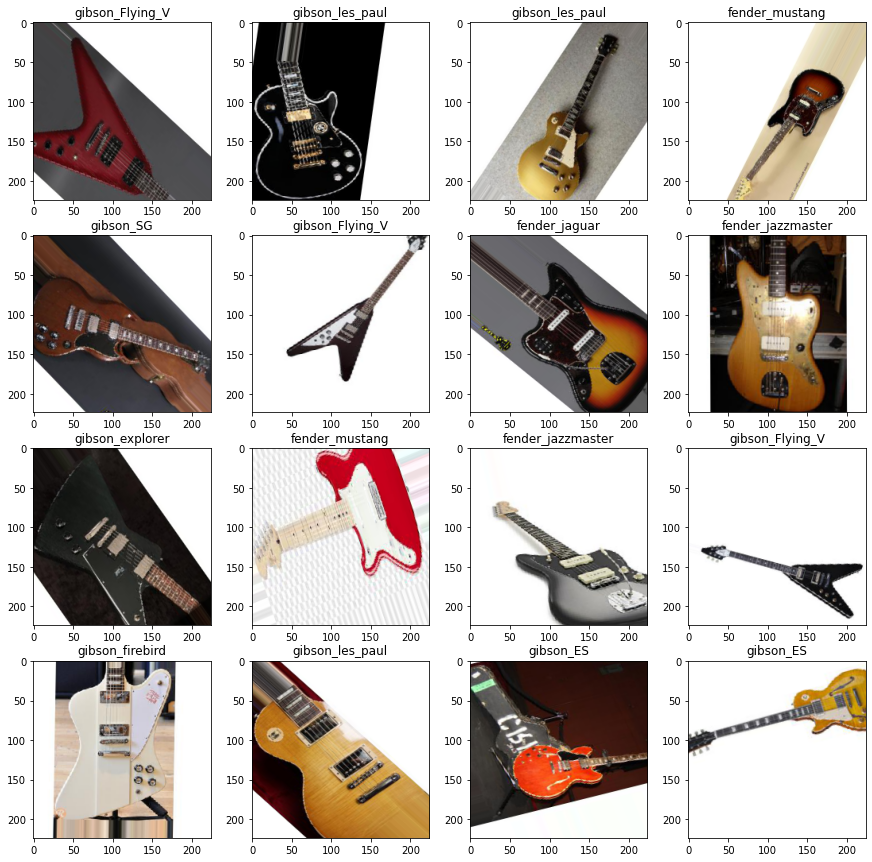

In [14]:
for X_batch, y_batch in train_datagen.flow_from_directory(train_path, batch_size=100, class_mode='sparse', target_size=(224, 224)):
    plt.figure(figsize=(15,15))
    # create a grid of 3x3 images
    for i in range(0, 16):
        ax = plt.subplot(4, 4, i+1)
        ax.set_title(findKey(train_generator.class_indices, y_batch[i]))
        plt.imshow((X_batch[i].reshape(224, 224, 3)*255).astype(np.uint8))
    # show the plot
    plt.show()
    break

In [148]:
dictresult={}
for k, v in files.items():
    if v not in dictresult:
        dictresult[v] = k
    else:
        dictresult[v].append(k)

In [149]:
dictresult

{0: 'fender_jaguar',
 1: 'fender_jazzmaster',
 2: 'fender_mustang',
 3: 'fender_stratocaster',
 4: 'fender_telecaster',
 5: 'gibson_ES',
 6: 'gibson_Flying_V',
 7: 'gibson_SG',
 8: 'gibson_explorer',
 9: 'gibson_firebird',
 10: 'gibson_les_paul'}

In [145]:
files=validation_generator.class_indices

In [142]:
np.array(my_dict)

array({'fender_jaguar': 0, 'fender_jazzmaster': 1, 'fender_mustang': 2, 'fender_stratocaster': 3, 'fender_telecaster': 4, 'gibson_ES': 5, 'gibson_Flying_V': 6, 'gibson_SG': 7, 'gibson_explorer': 8, 'gibson_firebird': 9, 'gibson_les_paul': 10},
      dtype=object)

In [158]:
class_names

array(['Fender_Jaguar', 'Fender_Jazzmaster', 'Fender_Mustang',
       'Fender_Stratocaster', 'Fender_Telecaster', 'Gibson_Es',
       'Gibson_Flying_V', 'Gibson_Sg', 'Gibson_Explorer',
       'Gibson_Firebird', 'Gibson_Les_Paul'], dtype='<U19')

In [165]:
def create_training_data(datadir, img_size):
    '''
    :param datadir: Specify the path to load.
    :param img_size: Specify the size of the image to reshape.
    :return: Returns a list of lists with images (X) and labels (y)
    '''
    lst = []
    categories = list(class_names)
    for category in categories:
        path = os.path.join(datadir, category)  # path to normal or pneumonia
        class_num = categories.index(category)  # Set category by index in categories: 0 -> Normal, 1 -> Pneumonia
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # read the original image
                new_array = cv2.resize(img_array, (img_size, img_size))  # resizes the original image to a IMG_SIZE
                lst.append([new_array, class_num])  # Appends to the list a tuple with array resized and each label
            except Exception as e:
                pass
    random.shuffle(lst)
    X, y = createxy(lst)
    X = np.array(X).reshape(-1, img_size, img_size, 1)
    return X,y

In [164]:
list(class_names)

['Fender_Jaguar',
 'Fender_Jazzmaster',
 'Fender_Mustang',
 'Fender_Stratocaster',
 'Fender_Telecaster',
 'Gibson_Es',
 'Gibson_Flying_V',
 'Gibson_Sg',
 'Gibson_Explorer',
 'Gibson_Firebird',
 'Gibson_Les_Paul']

In [27]:
# Función 
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from PIL import Image
import numpy as np
from skimage import transform
import tensorflow as tf

import urllib.request
import PIL

#Asign GPU for train
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

def prediction_label(img_path):
    model = load_model('./model/IncV3.h5')
    class_names = np.array(['fender_jaguar',
     'fender_jazzmaster',
     'fender_mustang',
     'fender_stratocaster',
     'fender_telecaster',
     'gibson_ES',
     'gibson_Flying_V',
     'gibson_SG',
     'gibson_explorer',
     'gibson_firebird',
     'gibson_les_paul'])
   
    try:
        np_image = Image.open(urllib.request.urlopen(img_path)) # Read from url
        display(np_image)
    except:
        np_image = Image.open(img_path) # Read from folder
        display(np_image)

    
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
#     fig=plt.imshow(np_image)
    np_image = np.expand_dims(np_image, axis=0)
    
    
    predictions=model.predict(np_image)
    
    classes = np.argmax(predictions, axis = 1)
    
#     fig.set_title(''.join(list(class_names[np.argmax(predictions, axis=-1)])))
#     plt.show(fig)
    
    return ''.join(list(class_names[np.argmax(predictions, axis=-1)]))

In [8]:
from tensorflow.keras.preprocessing import image

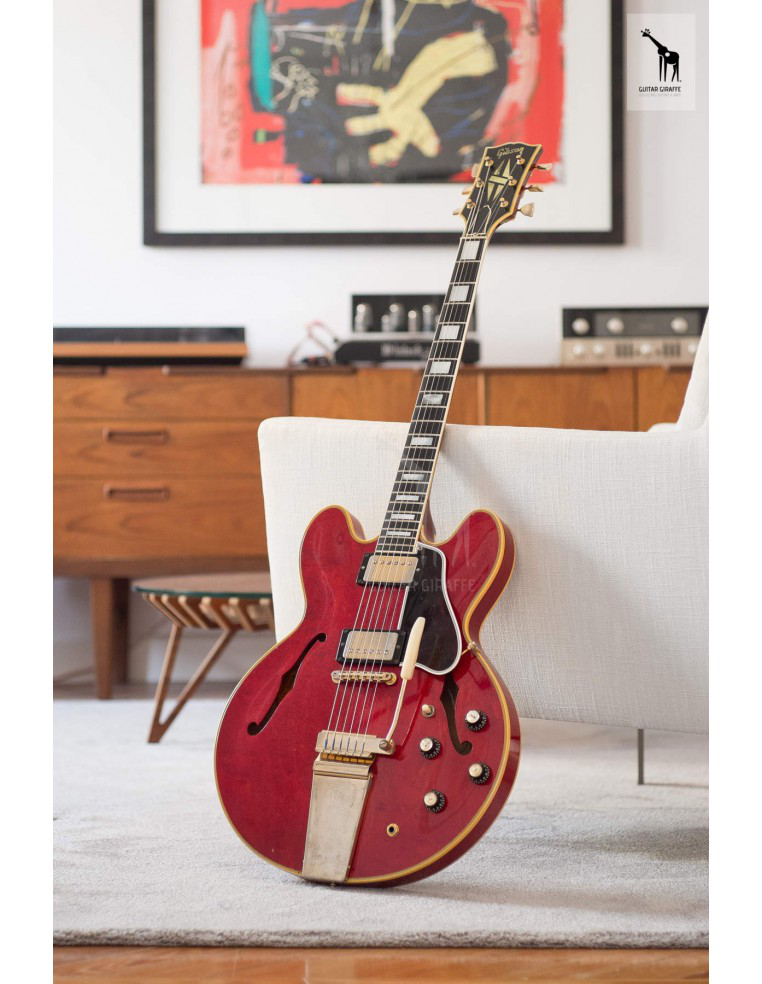

'gibson_ES'

In [28]:
prediction_label('./data/test/gibson_ES/02.jpg')

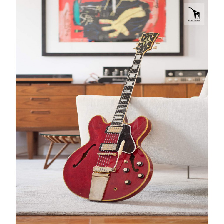

In [16]:
image.load_img('./data/test/gibson_ES/02.jpg', target_size=(224,224))

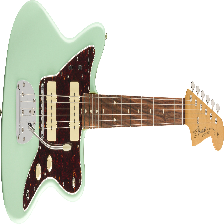

In [10]:
image.load_img('./data/test/fender_jazzmaster/0149763357_gtr_frt_001_rr.jpg',target_size=(224,224))

In [3]:
prediction_label('./data/test/fender_jazzmaster/0149763357_gtr_frt_001_rr.jpg')

'fender_jazzmaster'

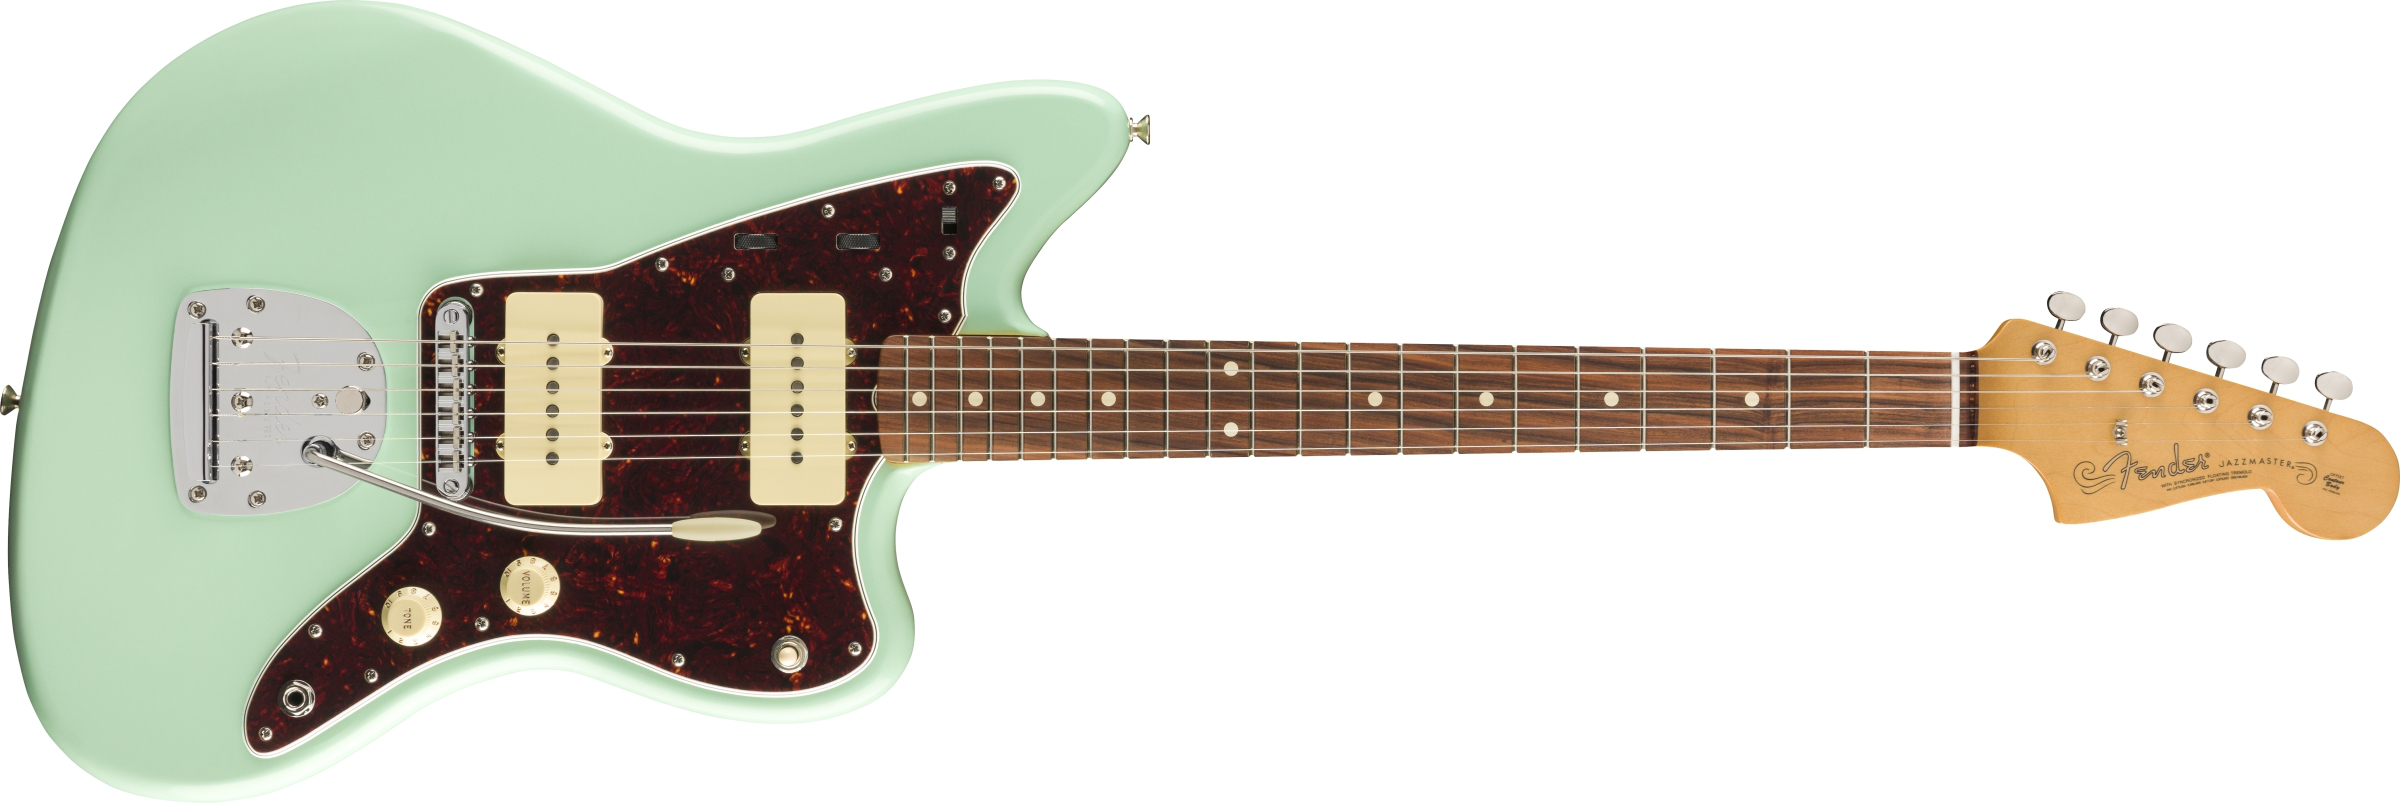

In [7]:
Image.open(urllib.request.urlopen('https://www.fmicassets.com/Damroot/ZoomJpg/10002/0149763357_gtr_frt_001_rr.jpg'))

In [4]:
prediction_label('https://www.fmicassets.com/Damroot/ZoomJpg/10002/0149763357_gtr_frt_001_rr.jpg')

'fender_jazzmaster'

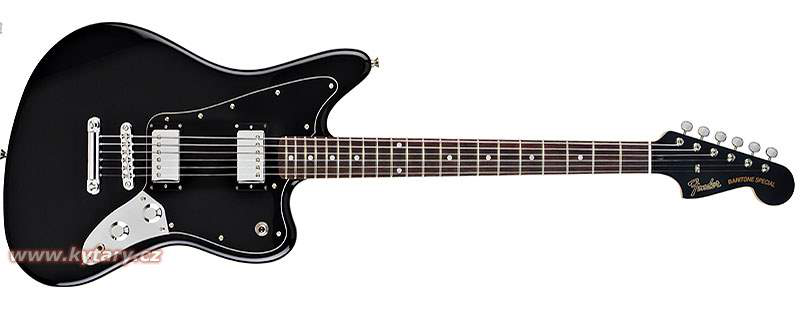

In [6]:
Image.open(urllib.request.urlopen('https://img.kytary.com/eshop_co_uk/velky_v2/na/633889898210000000/2ebba5d6/749973/fender-jaguar-baritone-special-hh.jpg'))

In [5]:
prediction_label('https://img.kytary.com/eshop_co_uk/velky_v2/na/633889898210000000/2ebba5d6/749973/fender-jaguar-baritone-special-hh.jpg')

'fender_jaguar'

In [67]:
import urllib.request
from PIL import Image
url = 'https://www.fmicassets.com/Damroot/ZoomJpg/10002/0149763357_gtr_frt_001_rr.jpg'
image = Image.open(urllib.request.urlopen(url))
width, height = image.size
# print (width,height)

In [6]:
image=image.resize((224, 224))

In [59]:
class_names = np.array(['fender_jaguar',
     'fender_jazzmaster',
     'fender_mustang',
     'fender_stratocaster',
     'fender_telecaster',
     'gibson_ES',
     'gibson_Flying_V',
     'gibson_SG',
     'gibson_explorer',
     'gibson_firebird',
     'gibson_les_paul'])


In [68]:
np_image=np.array(image).astype('float32')/255
np_image=transform.resize(np_image, (224,224,3))
np_image=np.expand_dims(np_image, axis=0)

predictions=model.predict(np_image)
classes = np.argmax(predictions, axis = 1)
list(class_names[np.argmax(predictions, axis=-1)])   

['fender_jazzmaster']

In [36]:
model = load_model('./model/IncV3.h5')

In [44]:
import numpy as np
import PIL
I = np.asarray(PIL.Image.open('./data/test/gibson_ES/02.jpg'))

In [29]:
from tensorflow.keras.preprocessing import image

In [27]:
img_path=('./data/test/gibson_ES/02.jpg')

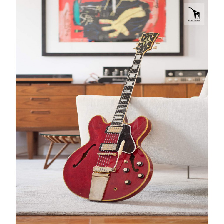

In [24]:
image.load_img(img_path,target_size=(224,224))

In [33]:
img=image.load_img(img_path, target_size=(180, 180))

In [22]:
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

In [46]:
my_model.predict(img, batch_size=1)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)